#### Script to extract tables from ICES Advice PDFs

Camelot works much better than Tabula in identifying the tables correctly, but some tweaks are needed. Especially, line_scale is required as some lines are too small for the default reader.

Problems identified:
1. Sometimes, advice is given by a range. These rows are deleted in the current version and a flag is added to check manually (e.g. advice in sol.27.4)
2. Unknown behaviour: Camelot doesn't recognize some cells (e.g. before 1990 in sol.27.7d). If the initial years of the timeseries are missing, we cannot identify it. If the missing cells are in between, we add a flag to check manually

The current version only works for cases with ONE advice table. There are PDFs with more than one table, e.g. 

To download the PDFs, refer to the code in /code/downAdvicePDF

In [237]:
import os
# import tabula
import pandas as pd
import PyPDF2
import re
import camelot
import numpy as np

In [2131]:
# read PDFs in directory
os.listdir('..\data\pdfsICES')
for file in os.listdir('..\data\pdfsICES'):
    print("'",os.path.splitext(file)[0],"', ", sep="")

'bli.27.5b67', 
'bss.27.4bc7ad-h', 
'bss.27.8ab', 
'cod.21.1', 
'cod.2127.1f14', 
'cod.27.1-2', 
'cod.27.21', 
'cod.27.22-24', 
'cod.27.47d20', 
'cod.27.5a', 
'cod.27.6a', 
'cod.27.7a', 
'cod.27.7e-k', 
'ghl.27.561214', 
'had.27.1-2', 
'had.27.46a20', 
'had.27.46a20_replaced-1', 
'had.27.46a20_replaced', 
'had.27.5a', 
'had.27.6b', 
'had.27.7a', 
'had.27.7b-k', 
'her.27.1-24a514a', 
'her.27.20-24', 
'her.27.25-2932', 
'her.27.28', 
'her.27.3031', 
'her.27.3a47d', 
'her.27.5a', 
'her.27.6a7bc', 
'her.27.irls', 
'her.27.nirs', 
'hke.27.3a46-8abd', 
'hke.27.8c9a', 
'hom.27.2a4a5b6a7a-ce-k8', 
'hom.27.9a', 
'ldb.27.8c9a', 
'lez.27.4a6a', 
'lez.27.6b', 
'lin.27.5a', 
'mac.27.nea', 
'meg.27.7b-k8abd', 
'meg.27.8c9a', 
'mon.27.78abd_replaced', 
'mon.27.8c9a', 
'nop.27.3a4', 
'ple.27.21-23', 
'ple.27.420_replaced-1', 
'ple.27.420_replaced', 
'ple.27.7a', 
'ple.27.7d', 
'ple.27.7fg', 
'pok.27.1-2', 
'pok.27.3a46', 
'pok.27.5a', 
'pra.27.1-2', 
'pra.27.3a4a', 
'reg.27.1-2', 
'reg.27.561214', 
's

In [2132]:
# define stock to extract
fishStock = 'bss.27.4bc7ad-h'

In [2133]:
# get page number in which Table 6 lies, and also get the next one as tables can span two oages
obj = PyPDF2.PdfFileReader("../data/pdfsICES/{}.pdf".format(fishStock))

pgno = obj.getNumPages()

#in some pdfs the Table 6 has more than one space between Table and 6
s = "Table[ ]{1,}6" 

for i in range(0, pgno):
    PgOb = obj.getPage(i)
    Text = PgOb.extractText()
    if re.search(s,Text):
         pages=str(i+1) + ',' + str(i+2) + ',' + str(i+3)
         print(pages)

5,6,7


In [2134]:
# from camelot import utils
# layout, dim = utils.get_page_layout(r'C:\Users\isaldiviagonzatti\Downloads\pdfsICES\spr.27.3a4.pdf')

In [2135]:
# read tables with Camelot. Using backend="poppler" as Ghostscript is not working for me
# table_area is not providing the expected results
# iterations had no effect for me
tables = camelot.read_pdf("../data/pdfsICES/{}.pdf".format(fishStock), 
                           pages=pages, 
                           backend="poppler", 
                           # flavor='stream',
                           # # table_areas accepts strings of the form x1,y1,x2,y2 where (x1, y1) -> top-left and (x2, y2)
                           # table_area=['0,600,590,700'],
                           # iterations=1,
                           line_scale=30,
                           # split_text=True,
                           strip_text=['#','^','<', '-', '≤', '***', '\n'],
                          )
print("Total tables extracted:", tables.n)

Total tables extracted: 15


In [2136]:
# delete tables before the first table in list that corresponds to table 6 (Advice) 
firstAdvice = [i for i, elem in enumerate(tables) if 'ICES advice' \
    in tables[i].df.iloc[0,:].to_list()][0]
tables = tables[firstAdvice:]

In [2137]:
# filter tables by two conditions:
# [0][0] is numeric and len(columns) is equal to the len(first table 6) 
# or the first row is equal to the first row of the first table 6

filterTableSix = [i for i, elem in enumerate(tables) if (pd.to_numeric\
    (tables[i].df[0].str.extract('(\d+)')[0][0], errors='coerce') > 0\
    and len(tables[i].df.columns) == len(tables[0].df.columns))\
    or tables[i].df.iloc[0,:].equals(tables[0].df.iloc[0,:]) == True
]

tableSix = [tables[i].df for i in filterTableSix]
tableSix = pd.concat(tableSix).reset_index(drop=True)

In [2146]:
# fix table 
icesTable = tableSix.copy()
icesTable.columns = icesTable.iloc[0,:]
icesTable = icesTable[1:].reset_index(drop=True)
icesTable['fishStock'] = fishStock
# sometimes the columns Year and ICES advice (text) don't split, we strip the text
icesTable['Year'] = icesTable['Year'].str.extract('(\d+)', expand=False)
icesTable = icesTable[icesTable['Year'].astype(str).str.isnumeric()]

# sometimes there is more than one space between the words in the columns
icesTable.rename(columns=lambda x: re.sub(r' +', ' ', x).strip(), inplace=True) # '[^a-zA-Z]+'

# replace columns names
dictCol = {'(?=.*[Cc]atch)(?=.*[Aa]dvice)': 'SAD', 
            '(?=.*[Ll]anding)(?=.*[Aa]dvice)': 'SAD_landings',
            '(?=.*TAC)': 'TAC',
            '(?=.*ICES)(?=.*[Ll]anding)': 'Landings',
            '(?=.*ICES)(?=.*[Cc]atch)': 'Catches (pdfs)',
            '(?=.*ICES)(?=.*[Dd]iscards)': 'Discards',} 

for key, value in dictCol.items():
    countCol = []
    for i in range(len(icesTable.columns.to_list())):
        count = bool(re.search(key, icesTable.columns[i]))
        countCol.append(count)
    # if more than one column name matches the regex, we don't rename them
    if countCol.count(True) == 1:
        for i in range(len(icesTable.columns.to_list())):
            if bool(re.search(key, icesTable.columns[i])) == True:
                icesTable.rename(columns = {icesTable.columns[i]:value}, inplace = True)

# fix numeric columns
numericCol = ['SAD', 'SAD_landings', 'TAC', 'Landings', 
'Year', 'Catches (pdfs)', 'Discards']
for col in icesTable.columns:
    if col in numericCol:
        # strip spaces between numbers
        icesTable[col] = icesTable[col].replace({' ': ''}, regex=True)
        # for cases in which there is an explanation of the number, we strip it
        icesTable[col] = icesTable[col].str.split('(').str[0]
        icesTable[col] = icesTable[col].apply(pd.to_numeric, errors='coerce')

icesTable = icesTable.replace({'': np.nan})

# if there is no SAD catch, we use SAD_landings
if 'SAD_landings' in icesTable.columns:
    icesTable['SAD'] = icesTable['SAD'].fillna(icesTable['SAD_landings'])

# define catches as landing + discards
if 'Landings' in icesTable.columns and 'Discards' in icesTable.columns:
    icesTable['catchesCal'] = icesTable['Landings'].fillna(0) + icesTable['Discards'].fillna(0)

# if there is no ICES Catches, we use catchCal
if 'Catches (pdfs)' in icesTable.columns:
    icesTable['Catches (pdfs)'] = icesTable['Catches (pdfs)'].fillna(icesTable['catchesCal'])
else:
    icesTable['Catches (pdfs)'] = icesTable['catchesCal']

    
icesTable.reset_index(drop=True, inplace=True)
icesTable

,Year,ICES advice,SAD,Official commercial landings,Landings,Discards,ICES recreational removals,fishStock,catchesCal,Catches (pdfs)
0,2000,NaN,NaN,2100,2407.0,NaN,NaN,bss.27.4bc7ad-h,2407.0,2407.0
1,2001,NaN,NaN,2200,2500.0,NaN,NaN,bss.27.4bc7ad-h,2500.0,2500.0
2,2002,No increase in effort or F,NaN,2400,2622.0,17.0,NaN,bss.27.4bc7ad-h,2639.0,2639.0
3,2003,No increase in effort or F,NaN,2900,3459.0,16.0,NaN,bss.27.4bc7ad-h,3475.0,3475.0
4,2004,No increase in effort or F,NaN,3000,3731.0,59.0,NaN,bss.27.4bc7ad-h,3790.0,3790.0
5,2005,NaN,NaN,3200,4430.0,96.0,NaN,bss.27.4bc7ad-h,4526.0,4526.0
6,2006,NaN,NaN,3396,4377.0,53.0,NaN,bss.27.4bc7ad-h,4430.0,4430.0
7,2007,NaN,NaN,3521,4064.0,50.0,NaN,bss.27.4bc7ad-h,4114.0,4114.0
8,2008,NaN,NaN,3027,4107.0,8.0,NaN,bss.27.4bc7ad-h,4115.0,4115.0
9,2009,NaN,NaN,4288,3889.0,151.0,NaN,bss.27.4bc7ad-h,4040.0,4040.0


In [2147]:
# Sandeel case
if 'san.sa' in fishStock:
    icesTable = icesTable.loc[:, ~icesTable.columns.str.contains('(?=.*[Tt]otal)(?=.*[Cc]atch)')]
    icesCatches = icesTable.columns.str.contains('(?=.*ICES)(?=.*[Cc]atch)')
    icesTable.iloc[:,np.where(icesCatches)[0][1]].fillna(icesTable.iloc[:,np.where(icesCatches)[0][0]], inplace=True)
    icesTable = icesTable.drop(columns=[icesTable.iloc[:,np.where(icesCatches)[0][0]].name])
    icesTable = icesTable.rename(columns={icesTable.iloc[:,np.where(icesCatches)[0][0]].name: 'Catches (pdfs)'})
    icesTable

In [2150]:
icesTable

,Year,ICES advice,SAD,Official commercial landings,Landings,Discards,ICES recreational removals,fishStock,catchesCal,Catches (pdfs),missingYear
0,2000,NaN,NaN,2100,2407.0,NaN,NaN,bss.27.4bc7ad-h,2407.0,2407.0,NaN
1,2001,NaN,NaN,2200,2500.0,NaN,NaN,bss.27.4bc7ad-h,2500.0,2500.0,NaN
2,2002,No increase in effort or F,NaN,2400,2622.0,17.0,NaN,bss.27.4bc7ad-h,2639.0,2639.0,NaN
3,2003,No increase in effort or F,NaN,2900,3459.0,16.0,NaN,bss.27.4bc7ad-h,3475.0,3475.0,NaN
4,2004,No increase in effort or F,NaN,3000,3731.0,59.0,NaN,bss.27.4bc7ad-h,3790.0,3790.0,NaN
5,2005,NaN,NaN,3200,4430.0,96.0,NaN,bss.27.4bc7ad-h,4526.0,4526.0,NaN
6,2006,NaN,NaN,3396,4377.0,53.0,NaN,bss.27.4bc7ad-h,4430.0,4430.0,NaN
7,2007,NaN,NaN,3521,4064.0,50.0,NaN,bss.27.4bc7ad-h,4114.0,4114.0,NaN
8,2008,NaN,NaN,3027,4107.0,8.0,NaN,bss.27.4bc7ad-h,4115.0,4115.0,NaN
9,2009,NaN,NaN,4288,3889.0,151.0,NaN,bss.27.4bc7ad-h,4040.0,4040.0,NaN


In [2149]:
# check if all years were read correctly by Camelot
checkYear = pd.Series(np.arange(icesTable.Year.iloc[0], icesTable.Year.iloc[-1]+1))
missingYear = checkYear[~checkYear.isin(icesTable.Year)].to_list()
if missingYear:
    allYears = pd.DataFrame(list(range(min(icesTable.Year), max(icesTable.Year+1))), columns=['Year'])
    icesTable = icesTable.merge(allYears, how='outer', on='Year').sort_values(by='Year').reset_index(drop=True)
    icesTable['missingYear'] = np.where(icesTable.fishStock.isnull(),1, np.nan)
    icesTable.fishStock = fishStock
    print('Years', missingYear, 'were not read correctly')
else:
    print('All years were read correctly')

Years [2015] were not read correctly


In [2068]:
# check for cases with SAD range which were not read correctly
specialYear = []
icesTable['missingSAD'] = np.nan
for value in range(len(icesTable['SAD']))[1:-1]:
        if np.isnan(icesTable['SAD'][value])\
        and ~np.isnan(icesTable['SAD'][value-1])\
        and ~np.isnan(icesTable['SAD'][value+1]): 
            specialYear.append(value)
            icesTable.loc[value, 'missingSAD'] = 1
if specialYear != []:
    print('Year(s)', icesTable['Year'][specialYear].values.tolist(), 'is a special case')
else:
    print('All years have a specific SAD value')

Year(s) [2011, 2020] is a special case


In [2069]:
# add columns from excel and reorganize
excelTable = (icesTable.reindex(['fishStock', 
'Most recent assessment with corresponding report',
 'Year','Catches (stockass)', 'SAD','TAC', 
 'Catches (pdfs)','done?', 'report','SAD_landings',
 'Landings','Discards','catchesCal','missingYear','missingSAD'], axis=1))
    
# icesTable = icesTable.replace('','N/A')
excelTable.set_index('fishStock', inplace=True)
excelTable.to_csv("../dataTemp/icesAdvice/{}.csv".format(fishStock))

,Most recent assessment with corresponding report,Year,Catches (stockass),SAD,TAC,Catches (pdfs),done?,report,SAD_landings,Landings,Discards,catchesCal,missingYear,missingSAD
fishStock,,,,,,,,,,,,,,
sol.27.7fg,NaN,1987,NaN,1600.0,1600.0,1222.0,NaN,NaN,1600.0,1222.0,NaN,1222.0,nan,NaN
sol.27.7fg,NaN,1988,NaN,900.0,1100.0,1146.0,NaN,NaN,900.0,1146.0,NaN,1146.0,nan,NaN
sol.27.7fg,NaN,1989,NaN,1000.0,1000.0,992.0,NaN,NaN,1000.0,992.0,NaN,992.0,nan,NaN
sol.27.7fg,NaN,1990,NaN,1200.0,1200.0,1189.0,NaN,NaN,1200.0,1189.0,NaN,1189.0,nan,NaN
sol.27.7fg,NaN,1991,NaN,1100.0,1200.0,1107.0,NaN,NaN,1100.0,1107.0,NaN,1107.0,nan,NaN
sol.27.7fg,NaN,1992,NaN,1100.0,1200.0,981.0,NaN,NaN,1100.0,981.0,NaN,981.0,nan,NaN
sol.27.7fg,NaN,1993,NaN,NaN,1100.0,928.0,NaN,NaN,NaN,928.0,NaN,928.0,nan,NaN
sol.27.7fg,NaN,1994,NaN,NaN,1100.0,1009.0,NaN,NaN,NaN,1009.0,NaN,1009.0,nan,NaN
sol.27.7fg,NaN,1995,NaN,1000.0,1100.0,1157.0,NaN,NaN,1000.0,1157.0,NaN,1157.0,nan,NaN


In [1773]:
# sum of spr.27.3a and spr.27.4 

spr4 = pd.read_csv("../dataTemp/icesAdvice/spr.27.4.csv")
spr3a = pd.read_csv("../dataTemp/icesAdvice/spr.27.3a.csv")
col_list = spr3a.columns.tolist()
spr4, spr3a = (df.set_index(['Year']).drop(columns=['fishStock']) for df in [spr4, spr3a])
spr3aHist = spr3a.add(spr4, fill_value=0)
spr3aHist['fishStock'] = 'spr.27.3a4'
spr3aHist.reset_index(inplace=True)
spr3aHist = spr3aHist[col_list]
spr3aHist.to_csv("../dataTemp/icesAdvice/spr.27.3a4bis.csv", index=False)

In [2110]:
# concat all the stock extracted

listStock = os.listdir('../dataTemp/icesMissing/')
listStock = [ '../dataTemp/icesMissing/' + s for s in listStock]
listStock
allStock = pd.DataFrame()
allStock = pd.concat([pd.read_csv(f) for f in listStock ])
allStock.to_csv( "../dataTemp/icesMissing.csv", index=False)

In [2121]:
# check what files in one folder are in the other folder

set(os.listdir('../data/missingICESpdfs/')) - set(os.listdir('../data/normalMissing/'))

{'cod.21.1.pdf',
 'cod.27.21.pdf',
 'cod.27.22-24.pdf',
 'cod.27.47d20.pdf',
 'had.27.46a20.pdf',
 'had.27.6b.pdf',
 'her.27.20-24.pdf',
 'her.27.3031.pdf',
 'her.27.3a47d.pdf',
 'her.27.5a.pdf',
 'her.27.6a7bc.pdf',
 'lez.27.4a6a.pdf',
 'lin.27.5a.pdf',
 'mac.27.nea.pdf',
 'nop.27.3a4.pdf',
 'pra.27.1-2.pdf',
 'pra.27.3a4a.pdf'}

C:\Users\isaldiviagonzatti\AppData\Local\Temp\ipykernel_2504\3259206825.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  camelot.plot(tables[0], kind='text').show()


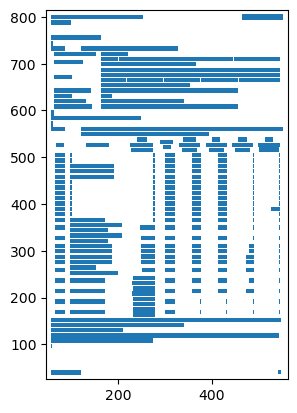

In [940]:
camelot.plot(tables[0], kind='text').show()

#### Trash

In [ ]:
# if len(tables) > 1:
#     # if table in same page is divided in two, then concatenate
#     if pd.to_numeric(tables[1].df[0][0], errors='coerce')> 0:
#         tableSix = pd.concat([tables[0].df, tables[1].df])
#     # if table is divided in two pages, then concatenate
#     elif tables[1].df.iloc[0,:].equals(tables[0].df.iloc[0,:]) == True:
#         tableSix = pd.concat([tables[0].df, tables[1].df])
#     else:
#         tableSix = tables[0].df
# if len(tables) > 2:
#     # if table is divided in two pages, then concatenate
#     if tables[2].df.iloc[0,:].equals(tables[0].df.iloc[0,:]) == True:
#         tableSix = pd.concat([tableSix, tables[2].df])
#     elif pd.to_numeric(tables[2].df[0][0], errors='coerce')> 0:
#         tableSix = pd.concat([tableSix, tables[2].df])
        
# tableSix

#### From tabula

In [162]:
# tables = tabula.read_pdf(r"C:\Users\isaldiviagonzatti\Downloads\pdfsICES\spr.27.3a4.pdf", multiple_tables=True, 
#                           pages=page, lattice=True, guess=True, java_options="-Dfile.encoding=UTF8")                        


In [159]:
# tabula.convert_into("file:///C:/Users/isaldiviagonzatti/OneDrive%20-%20Kiel%20Institut%20f%C3%BCr%20Weltwirtschaft/Documents/General/Ignacio/data/pdf_ices_test/bli.27.5b67.pdf", r"C:/Users/isaldiviagonzatti//Downloads/test.csv", output_format="csv", stream=True, pages='4')

In [ ]:
# i=1
# for table in tables:
#     table.columns = table.iloc[0]
#     table = table.reindex(table.index.drop(0)).reset_index(drop=True)
#     table.columns.name = None
#     #To write Excel
#     table.to_excel('output'+str(i)+'.xlsx',header=True,index=False)
#     #To write CSV
#     table.to_csv('output'+str(i)+'.csv',sep='|',header=True,index=False)
#     i=i+1